<a href="https://colab.research.google.com/github/utkarsh512/ABSA-Bert/blob/main/notebooks/4_TensorFlow_Bert_Change_My_View_LIME.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Bert on Change My View dataset using TensorFlow
* __Objective__: Finetuning Bert on CMV dataset
* __Functionalities__: Allows training and testing Bert on CMV dataset by varying the proporation of training examples to build an exhaustive table for Bert for one-on-one comparison with GAN-Bert, producing LIME visualization of comments
* __File Manager__: Google Drive
* __Runtime Type__: GPU
* __Notes__: Upload [this](https://github.com/utkarsh512/Ad-hominem-fallacies/blob/master/experiments/comment.py) script in Google Colab local folder and visit [this](https://www.tensorflow.org/text/tutorials/classify_text_with_bert) page to get an insight about format of dataset


## Loading required libraries and setting environment for training

In [ ]:
!nvidia-smi

Fri May 14 15:06:43 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.19.01    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   68C    P8    33W / 149W |      3MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install -q tensorflow-text
!pip install -q tf-models-official

     |████████████████████████████████| 3.4MB 14.0MB/s 
     |████████████████████████████████| 1.6MB 14.2MB/s 
     |████████████████████████████████| 645kB 50.5MB/s 
     |████████████████████████████████| 1.2MB 51.2MB/s 
     |████████████████████████████████| 38.2MB 77kB/s 
     |████████████████████████████████| 686kB 49.2MB/s 
     |████████████████████████████████| 102kB 11.8MB/s 
     |████████████████████████████████| 51kB 8.8MB/s 
     |████████████████████████████████| 454.3MB 36kB/s 
     |████████████████████████████████| 358kB 44.3MB/s 
     |████████████████████████████████| 61kB 8.9MB/s 
     |████████████████████████████████| 174kB 59.7MB/s 
     |████████████████████████████████| 4.0MB 37.8MB/s 
     |████████████████████████████████| 4.0MB 42.3MB/s 
     |████████████████████████████████| 6.0MB 41.6MB/s 
     |████████████████████████████████| 471kB 39.5MB/s 
     |████████████████████████████████| 1.2MB 32.3MB/s 
     |████████████████████████████████| 4.9MB 42.9MB/

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optmizer

tf.get_logger().setLevel('ERROR')

NotFoundError: ignored

In [ ]:
# Allow memory growth for the GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
!pip install lime

     |████████████████████████████████| 276kB 4.4MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=b3377a289750d52c074bd95fa66f88c5dcf1d996e0ed5f580f0f408b742bbd97
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
import os

if tf.test.is_gpu_available():
  strategy = tf.distribute.MirroredStrategy()
  print('Using GPU')
else:
  raise ValueError('Running on CPU is not recomended.')

Using GPU


In [ ]:
os.environ["TFHUB_MODEL_LOAD_FORMAT"]="UNCOMPRESSED"

In [ ]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [ ]:
from tqdm import tqdm
from comment import Comment # Needed to be manually uploaded, file available at https://github.com/utkarsh512/Ad-hominem-fallacies/blob/master/experiments/comment.py
import pickle

## Mounting Google Drive and preparing dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
train_dir = '/content/gdrive/MyDrive/DL/dataset/bert/train'
test_dir = '/content/gdrive/MyDrive/DL/dataset/bert/test'

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0, # change this to change number of training examples
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 5242 files belonging to 2 classes.
Using 787 files for training.
Found 2000 files belonging to 2 classes.


## Building and training Bert

In [ ]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
with strategy.scope():
    loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    metrics = tf.metrics.BinaryAccuracy()
    epochs = 3
    steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
    num_train_steps = steps_per_epoch * epochs
    num_warmup_steps = int(0.1*num_train_steps)

    init_lr = 3e-5
    optimizer = optimization.create_optimizer(init_lr=init_lr, num_train_steps=num_train_steps, num_warmup_steps=num_warmup_steps, optimizer_type='adamw')
    classifier_model = build_classifier_model()
    classifier_model.compile(optimizer=optimizer, loss=loss, metrics=metrics)
    print(f'Training model with {tfhub_handle_encoder}')
    history = classifier_model.fit(x=train_ds, epochs=epochs)

## Predicting class labels
Use this when you have to calculate performance metrics for different number of training examples

In [ ]:
indir = '/content/gdrive/MyDrive/DL/dataset/bert_2_to_18.log'
outdir = '/content/gdrive/MyDrive/DL/dataset/lol.log'

reader = open(indir, 'rb')

comments = []

e = Comment(0, 'lol geez', 'ah')

try:
    while True:
        e = pickle.load(reader)
        print(e)
        comments.append(e)
except EOFError:
    reader.close()

for i in tqdm(range(len(comments))):
    text = list()
    text.append(comments[i].text)
    result = tf.sigmoid(classifier_model(tf.constant(text)))
    score = float(result[0][0])
    label = 'none'
    if score < 0.5:
        score = 1 - score
        label = 'ah'
    words = None
    comments[i].add_model('BERT_15', label, score, words)

writer = open(outdir, 'wb')
for i in tqdm(range(len(comments))):
    pickle.dump(comments[i], writer)
writer.close()

for x in comments:
    print(x.labels)
    print(x.scores)
    print("-" * 30)

Streaming output truncated to the last 5000 lines.
id: 710
comment: no hes right in his usage of the word anecdote since in scientific context that is what all single events are unless they are collected and made into statistics wtf a terrorist attack isnt an anecdote in any context you inarticulate nancy
label: ah

id: 711
comment: there has never been a revolution in a developed democracy not a single one anywhere in the world that doesnt mean there never will be one but to say that such a thing is inevitable in the complete and utter absence of evidence is foolish on its face
label: none

id: 712
comment: you clearly dont know what the word strawman means
label: ah

id: 713
comment: you are correct but that doesnt make it not rude
label: none

id: 714
comment: prove it you are making wild assertions without proof get real dude pastafarianism is literally a meme people participate ironically it is well known youre just being an ass
label: ah

id: 715
comment: so what youre saying is 

  0%|          | 0/2000 [00:00<?, ?it/s]

id: 1960
comment: i notice you still havent responded to the other guy about whether people should disclose infertility on the first date remember not leaving a comment speaks volumes none of them ever respond to that because people who use infertility as an excuse to abuse lgbt people dont really believe what they pretend to believe about infertility its just an excuse to be lying bigots
label: ah

id: 1961
comment: i think we as a society need to be more open to pedophiles who admit theyre feeling sexually attracted to children currently it really isnt a great idea to do that in most places that said after they are guilty of molestation shame is pretty reasonable if you want to give any free will to people you have to blame them for bad behaviour thoughts are a slightly separate matter though
label: none

id: 1962
comment: we are taking about clinton because that is what this specific chain is about dont comment if you wan na have a decent conversation like the rest of us were having

100%|██████████| 2000/2000 [00:00<00:00, 32334.64it/s]


Streaming output truncated to the last 5000 lines.
{'bert': 0.9378126189112663, 'cnn': 0.67654717, 'bilstm': 0.60124993, 'bert-5': 0.9063384160399437, 'bert-10': 0.8743482530117035, 'bert-20': 0.9896246930584311, 'bert-30': 0.9669492207467556, 'BERT_2': 0.5291740894317627, 'BERT_4': 0.6554844975471497, 'BERT_6': 0.7627405375242233, 'BERT_8': 0.8229548931121826, 'BERT_10': 0.8276268839836121, 'BERT_12': 0.8785195797681808, 'BERT_14': 0.8810922354459763, 'BERT_16': 0.9105559587478638, 'BERT_18': 0.9226559475064278, 'BERT_15': 0.9206048250198364}
------------------------------
{'bert': 'ah', 'cnn': 'ah', 'bilstm': 'none', 'bert-5': 'none', 'bert-10': 'none', 'bert-20': 'none', 'bert-30': 'none', 'BERT_2': 'ah', 'BERT_4': 'ah', 'BERT_6': 'ah', 'BERT_8': 'none', 'BERT_10': 'ah', 'BERT_12': 'ah', 'BERT_14': 'ah', 'BERT_16': 'ah', 'BERT_18': 'none', 'BERT_15': 'none'}
{'bert': 0.9754031617194414, 'cnn': 0.6688594, 'bilstm': 0.53095317, 'bert-5': 0.7169830799102783, 'bert-10': 0.52552479505538

## LIME visualization

In [ ]:
import numpy as np

# helper functions for lime visualization

# define softmax function
def softmax(x):
    return 1 / (1 + np.exp(-x))

# define prediction function
def predict_probs(texts):
    predictions = classifier_model.predict(texts)
    pr = list(predictions)
    nr = list()
    for x in pr:
        y = list(x)
        y = y[0]
        y = softmax(y)
        z = 1 - y
        ff = list()
        ff.append(z)
        ff.append(y)
        ff = np.array(ff)
        nr.append(ff)
    nr = np.array(nr)
    return nr

In [ ]:
import pickle
from comment import Comment 

# upload comment.py in the local file system of Colab 
# It is available at https://github.com/utkarsh512/Ad-hominem-fallacies/blob/master/experiments/comment.py

comments = list()

data_dir = '/content/gdrive/MyDrive/DL/dataset/lol.log'

e = Comment(-1, 'lol', 'ah')
f = open(data_dir, 'rb')

try:
    while True:
        e = pickle.load(f)
        comments.append(e)
except EOFError:
    f.close()

print(len(comments))

2000


In [ ]:
# Finding high confidence Bert comments

pred = list()
for i in range(len(comments)):
    label = comments[i].labels['BERT_15']
    glabel = comments[i].label
    if label == 'ah' and glabel == 'ah':
        score = comments[i].scores['BERT_15']
        pred.append((score, i))

In [ ]:
sorted(pred, reverse=True)

[(0.95891347900033, 1298),
 (0.9568241238594055, 1854),
 (0.9541139900684357, 810),
 (0.9539427757263184, 1254),
 (0.9533077217638493, 1178),
 (0.9518567472696304, 1812),
 (0.9511690177023411, 914),
 (0.9508584402501583, 1032),
 (0.9504279755055904, 1718),
 (0.9504054971039295, 1952),
 (0.9503381438553333, 434),
 (0.950277641415596, 932),
 (0.949579481035471, 496),
 (0.9494243413209915, 196),
 (0.949245598167181, 1844),
 (0.949054192751646, 314),
 (0.9485104717314243, 1852),
 (0.9482614323496819, 1042),
 (0.9477314911782742, 1842),
 (0.9476884976029396, 1536),
 (0.9475932121276855, 978),
 (0.9475225731730461, 494),
 (0.9475041255354881, 770),
 (0.9472663290798664, 1378),
 (0.9472626373171806, 1262),
 (0.9472165070474148, 930),
 (0.9471405930817127, 24),
 (0.9465556181967258, 588),
 (0.946300383657217, 1086),
 (0.9461278505623341, 1688),
 (0.9458801336586475, 730),
 (0.9458385296165943, 250),
 (0.9456183165311813, 1374),
 (0.9452466480433941, 414),
 (0.9452327266335487, 1658),
 (0.94520

In [ ]:
highConf_text = list()
for i in range(10):
    x, y = pred[i]
    highConf_text.append(comments[y].text)

In [ ]:
print(highConf_text)

['how dare people be poor so unreasonable fucking you', 'i think hes a legit troll', 'thats irrelevant i made my comment shortly after the comment i responded to thats all that matters if you had already changed your mind then you shouldnt be using the argument from ignorance both were nine days agowhy you are dredging this up now is beyond me are you lonely we could talk about something much more constructive than this', 'ohhh does this mean i cant buy a house or decide to go to school bc i have a mental illness yes mentally ill people make rational decisions all the time like suicide and you dont get to write of them or their decisions as irrational because theyre mentally ill yes i do this is a dangerous form of ableism youre infantalizing the mentally ill refusing them agency and youre an sjw who can rape a thesaurus good job', 'repeatedly telling me that i dont know charity exists is trolling you are an enemy to your own cause crawl back under your bridge', 'so im expected to find

In [ ]:
# Finding high confidence GANBert comments 

data_dir = '/content/gdrive/MyDrive/ganbert/ganbert_output_model/test_results.tsv'
pred = list()
line = None
with open(data_dir, 'r') as f:
    line = f.readlines()
for x in line:
    x = x.strip().split('\t')
    pred.append(x[1])

In [ ]:
highConf = list()
for i in range(2000):
    gold_label = comments[i].label 
    if gold_label == 'ah':
        highConf.append((pred[i], i))

In [ ]:
sorted(highConf, reverse=True)

[('9.4956784e-05', 244),
 ('9.4956784e-05', 242),
 ('9.4956784e-05', 240),
 ('9.048342e-05', 658),
 ('9.048342e-05', 656),
 ('0.99967456', 554),
 ('0.99967456', 552),
 ('0.99967456', 550),
 ('0.9996113', 1504),
 ('0.9996113', 1502),
 ('0.9996113', 1500),
 ('0.9996055', 654),
 ('0.9996055', 652),
 ('0.9996055', 650),
 ('0.99959975', 1004),
 ('0.99959975', 1002),
 ('0.99959975', 1000),
 ('0.99959975', 704),
 ('0.99959975', 702),
 ('0.99959975', 700),
 ('0.99959', 594),
 ('0.99959', 592),
 ('0.99959', 590),
 ('0.9995797', 1784),
 ('0.9995797', 1782),
 ('0.9995797', 1780),
 ('0.999579', 1104),
 ('0.999579', 1102),
 ('0.999579', 1100),
 ('0.9995789', 494),
 ('0.9995789', 492),
 ('0.9995789', 490),
 ('0.99956685', 1884),
 ('0.99956685', 1882),
 ('0.99956685', 1880),
 ('0.9995664', 1694),
 ('0.9995664', 1692),
 ('0.9995664', 1690),
 ('0.99956137', 1254),
 ('0.99956137', 1252),
 ('0.99956137', 1250),
 ('0.99955577', 1344),
 ('0.99955577', 1342),
 ('0.99955577', 1340),
 ('0.9995541', 1988),
 ('

In [ ]:
highConf_text = list()
for i in range(10):
    x, y = highConf[i]
    highConf_text.append(comments[y].text)

In [ ]:
highConf_text

['how dare people be poor so unreasonable fucking you',
 'at least i have a great home life and i am happy unlike them who will die barren and alone im sorry that you feel the need to lash out it sure doesnt sound like youre very happy',
 'i think hes a legit troll',
 'thats irrelevant i made my comment shortly after the comment i responded to thats all that matters if you had already changed your mind then you shouldnt be using the argument from ignorance both were nine days agowhy you are dredging this up now is beyond me are you lonely we could talk about something much more constructive than this',
 'ohhh does this mean i cant buy a house or decide to go to school bc i have a mental illness yes mentally ill people make rational decisions all the time like suicide and you dont get to write of them or their decisions as irrational because theyre mentally ill yes i do this is a dangerous form of ableism youre infantalizing the mentally ill refusing them agency and youre an sjw who can

In [ ]:
data_dir = '/content/gdrive/MyDrive/DL/dataset/ganbert_hc.txt'

with open(data_dir, 'w') as f:
    for x in highConf_text:
        f.write(x)
        f.write('\n')

In [ ]:
# Building confusion matrix for CNN, BiLSTM and Bert model

CNN = dict()
BiLSTM = dict()
BERT = dict()


high_conf_ah = list()

thr = 0.9985

for c in comments:
    gold_label = c.label
    bert_label = c.labels['bert']
    cnn_label = c.labels['cnn']
    bilstm_label = c.labels['bilstm']

    bert_score = c.scores['bert']
    cnn_score = c.scores['cnn']
    bilstm_score = c.scores['bilstm']

    bert_ = gold_label + '_' + bert_label
    cnn_ = gold_label + '_' + cnn_label
    bilstm_ = gold_label + '_' + bilstm_label

    try:
        BERT[bert_] += 1
    except:
        BERT[bert_] = 1
    try:
        CNN[cnn_] += 1
    except:
        CNN[cnn_] = 1
    try:
        BiLSTM[bilstm_] += 1
    except:
        BiLSTM[bilstm_] = 1

    if gold_label == 'ah' and bert_label == 'ah' and cnn_label == 'ah' and bilstm_label == 'ah':
        if bert_score > thr and cnn_score > thr and bilstm_score > thr:
            high_conf_ah.append(c.text)

In [ ]:
print(len(high_conf_ah))

13


In [ ]:
print(BERT)

{'ah_ah': 840, 'none_none': 837, 'ah_none': 160, 'none_ah': 163}


In [ ]:
print(BiLSTM)

{'ah_ah': 885, 'none_none': 567, 'ah_none': 115, 'none_ah': 433}


In [ ]:
print(BERT_30)

{'ah_ah': 806, 'none_none': 811, 'ah_none': 194, 'none_ah': 189}


In [ ]:
print(CNN)

{'ah_ah': 876, 'none_none': 701, 'ah_none': 124, 'none_ah': 299}


In [ ]:
from lime.lime_text import LimeTextExplainer
explainer = LimeTextExplainer(class_names = class_names)

In [ ]:
from tqdm import tqdm

DIR = '/content/gdrive/MyDrive/DL/dataset/lime/bert_highconf'

with strategy.scope():
    for idx in tqdm(range(len(highConf_text))):
        text = highConf_text[idx]
        exp = explainer.explain_instance(text, predict_probs, num_features=5, num_samples=20)
        writer = os.path.join(DIR, f'comment_{idx}.html')
        exp.save_to_file(writer)

100%|██████████| 10/10 [00:07<00:00,  1.27it/s]


## Building confusion matrix

In [ ]:
# Building confusion matrix for CNN, BiLSTM and Bert model

BERT = dict()

for i in range(2, 19, 2):
    model_name = 'BERT_' + str(i)
    BERT[model_name] = dict()

for c in comments:
    gold_label = c.label

    for i in range(2, 19, 2):
        model_name = 'BERT_' + str(i)
        model_label = c.labels[model_name]
        model_score = c.scores[model_name]
        model_label_ = gold_label + '_' + model_label
        try:
            BERT[model_name][model_label_] += 1
        except:
            BERT[model_name][model_label_] = 1

In [ ]:
for key in BERT.keys():
    print(f'{key}: {BERT[key]}')

BERT_2: {'ah_ah': 682, 'none_none': 517, 'ah_none': 318, 'none_ah': 483}
BERT_4: {'ah_ah': 964, 'none_ah': 796, 'none_none': 204, 'ah_none': 36}
BERT_6: {'ah_ah': 732, 'none_none': 746, 'ah_none': 268, 'none_ah': 254}
BERT_8: {'ah_ah': 684, 'none_none': 773, 'ah_none': 316, 'none_ah': 227}
BERT_10: {'ah_ah': 594, 'none_none': 848, 'ah_none': 406, 'none_ah': 152}
BERT_12: {'ah_ah': 725, 'none_none': 778, 'none_ah': 222, 'ah_none': 275}
BERT_14: {'ah_ah': 762, 'none_none': 728, 'none_ah': 272, 'ah_none': 238}
BERT_16: {'ah_ah': 792, 'none_none': 720, 'none_ah': 280, 'ah_none': 208}
BERT_18: {'ah_ah': 792, 'none_none': 752, 'ah_none': 208, 'none_ah': 248}


In [ ]:
bert_acc = [0.677, 0.785, 0.804, 0.811, 0.824, 0.831, 0.836, 0.832, 0.837, 0.839]
gan_acc = [0.777, 0.792, 0.798, 0.798, 0.807, 0.813, 0.814, 0.820, 0.818, 0.818]
bert_f1 = [0.671, 0.784, 0.803, 0.811, 0.823, 0.830, 0.836, 0.831, 0.837, 0.838]
gan_f1 = [0.777, 0.792, 0.798, 0.798, 0.807, 0.812, 0.814, 0.820, 0.817, 0.814]
x = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100]

bert_acc_ = [0.6, 0.584, 0.739, 0.729, 0.721, 0.752, 0.745, 0.756, 0.772, 0.785]
gan_acc_ = [0.678, 0.746, 0.739, 0.752, 0.767, 0.783, 0.777, 0.793, 0.790, 0.792]
bert_f1_ = [0.597, 0.514, 0.739, 0.728, 0.716, 0.751, 0.745, 0.756, 0.772, 0.784]
gan_f1_ = [0.677, 0.745, 0.739, 0.752, 0.766, 0.782, 0.777, 0.792, 0.789, 0.792]
x_ = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

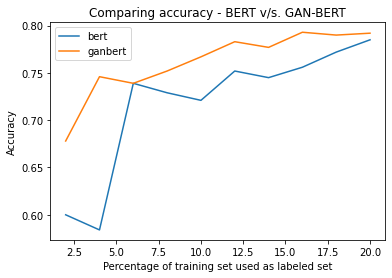

In [ ]:
import matplotlib.pyplot as plt
# plt.figure(dpi = 400)
plt.plot(x_, bert_acc_, label='bert')
plt.plot(x_, gan_acc_, label='ganbert')
plt.xlabel('Percentage of training set used as labeled set')
plt.ylabel('Accuracy')
plt.title('Comparing accuracy - BERT v/s. GAN-BERT')
plt.legend()
plt.show()

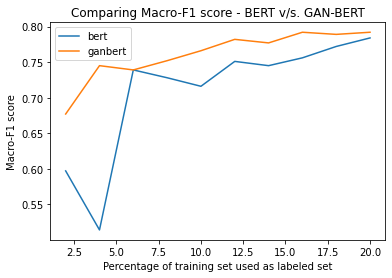

In [ ]:
# plt.figure(dpi = 400)
plt.plot(x_, bert_f1_, label='bert')
plt.plot(x_, gan_f1_, label='ganbert')
plt.xlabel('Percentage of training set used as labeled set')
plt.ylabel('Macro-F1 score')
plt.title('Comparing Macro-F1 score - BERT v/s. GAN-BERT')
plt.legend()
plt.show()